In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import multivariate_normal
from utils import randncor,knn

plt.style.use(['seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['font.family'] = 'DejaVu Sans'

from IPython.display import HTML

# Распознавание образов на основе непараметрических алгоритмов оценивания плотности распределения случайной величины

Используя код Вашей лабораторной №3, реализуйте алгоритм распознавания образов, применив оценивание по методу k ближайших соседей. Вычислите экспериментально вероятности ошибок распознавания. Сравните их с вероятностями ошибок (теоретическими или экспериментальными), полученными в ходе выполнения лабораторной №3. Отобразите поверхности плотностей распределения классов, задаваемых теоретически, и полученных в результате оценивания.

## Задание исходных данных

Рассмотрим случай распознавания образов описываемых двумерными гауссовскими векторами.

Даны математические ожидания случайных векторов
$
m_1=
  \begin{bmatrix}
    10 & -2
  \end{bmatrix}
$,
$m_2=
  \begin{bmatrix}
    -4 & 3
  \end{bmatrix}
$,
$m_3=
  \begin{bmatrix}
    1 & -2
  \end{bmatrix}
$  
и матрицы ковариаций:
$$С_1=
  \begin{bmatrix}
    2 & -1\\
    -1 & 3
  \end{bmatrix}
$$

$$С_2=
  \begin{bmatrix}
     5 & 1\\
     1 & 5
  \end{bmatrix}
$$

$$С_3=
  \begin{bmatrix}
     4 & -1\\
    -1 & 4
  \end{bmatrix}
$$

Зададим следующие априорные вероятности: $$p(\omega_1) = 0.2$$ $$p(\omega_2) = 0.5$$ $$p(\omega_3) = 0.3$$

In [2]:
n = 2
M = 3
m1,m2,m3 = np.array([10,-2]),np.array([-4,3]),np.array([1,-2])
m = [m1,m2,m3]
C1, C2, C3 = np.array([[2, -1],[-1, 3]]), np.array([[5, 1],[1, 5]]),np.array([[4, -1],[-1, 4]])
C = [C1,C2,C3]
pw = [0.2,0.5,0.3]

In [3]:
def generate_sample(n,M,NN,mM,C,vis = False):

    N=np.sum(NN)#общее количество генерируемых выборок

    XN=list()
    #Организация цикла генерации выборок по номерам классов
    for k in range(M):
        XN.append(np.zeros((n,NN[k]))) 
        mMk=mM[k] 
        Ck=C[k]
        XNk=np.zeros((n,NN[k]))
        for i in range(NN[k]):#генерация выборок
            XNk[:,i]=(randncor(n,1,Ck)+mMk.reshape(-1,1)).T
        XN[k]=XNk
    
    M_=M 
    if M>4:
        M_=4
    #Контрольная визуализация полученных выборок для двумерного вектора признаков и M<5
    if vis and n>1:
        markers = ['Blues','Reds','Greens']
        for k in range(M_):
            XNk = XN[k]
            ax = sns.kdeplot(XNk[0,:], XNk[1,:],cmap=markers[k], shade=True,shade_lowest=False)
            ax.set_xlabel('x1')
            ax.set_ylabel('x2')
    return XN

Плотности распределения случайных векторов с указанными параметрами имеют следующий вид:

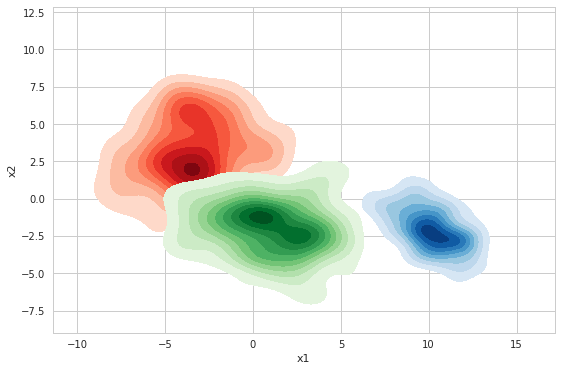

In [5]:
N = 100
NN = N*np.ones(M,dtype=int)
sample = generate_sample(n,M,NN,m,C,vis=True) 

Визуализация выборок из лабораторной работы №3:

<img src = "img/prev.png">

## Решение

### Расчет вероятностей ошибок распознавания

Установим параметры моделирования:


In [17]:
Nn=list(range(10,100,10))+ list(range(100,1000,50))# размеры обучающей выборки
ln=len(Nn)
Esth2,Esex2,Ekek2=np.zeros(ln),np.zeros(ln),np.zeros(ln)
gm=0.25
H=1 #количество статистических испытаний процесса обучения
K=1000 #количество статистических испытаний алгоритма распознавания

Для оценки плотности распределения мы будем применять метод k ближайших соседей. Чтобы оценить качество алгоритма, используем метод скользящего контроля.

In [18]:
for nn in range(ln):
    NN=Nn[nn]*np.ones(M,dtype=int)
    N=Nn[nn]
    k=2*round(N**gm)+1
    XN=generate_sample(n,M,NN,m,C,vis=False)
    Pc2=np.zeros((M,M))
    p2_=np.zeros((M,1))
    for i in range(M):
        XNi=XN[i]
        XNi_=np.zeros((n,N-1))
        indi = list(range(M))
        indi.remove(i)
        for j in range(N):
            x=XNi[:,j]
            indj=list(range(N))
            indj.remove(j)
            XNi_[:,0:j]=XNi[:,0:j]
            XNi_[:,j:]=XNi[:,j+1:]
            p2_[i]=knn(x,XNi_,k)
            for t in range(M-1):
                ij=indi[t]
                p2_[ij]=knn(x,XN[ij],k)
            iai2=p2_.argmax()
            Pc2[i,iai2]=Pc2[i,iai2]+1
        Pc2[i,:]=Pc2[i,:]/N;
    Esth2[nn]=Esth2[nn]+(1-np.sum(pw*np.diag(Pc2)))
    
    #cтатистические испытания
    Pc1_=np.zeros((M,M))
    Pc2_=np.zeros((M,M))
    X=generate_sample(n,M,K*np.ones(M,dtype=int),m,C,vis = False)
    p2x=np.zeros((M,K))

    for i in range(M):
        xi=X[i]
        for j in range(M):
            p2x[j,:]=knn(xi,XN[j],k)
        mai2=p2x.argmax(axis = 0)
        ni2=np.nonzero(mai2==i)
        Pc2_[i,i]=len(ni2[0])/K
    Esex2[nn]=Esex2[nn]+(1-np.sum(pw*np.diag(Pc2_)))
Esth2=Esth2/H
Esex2=Esex2/H

### Результаты моделирования

Построим график зависимости суммарной вероятности ошибки при распознавании от размера обучающей выборки:

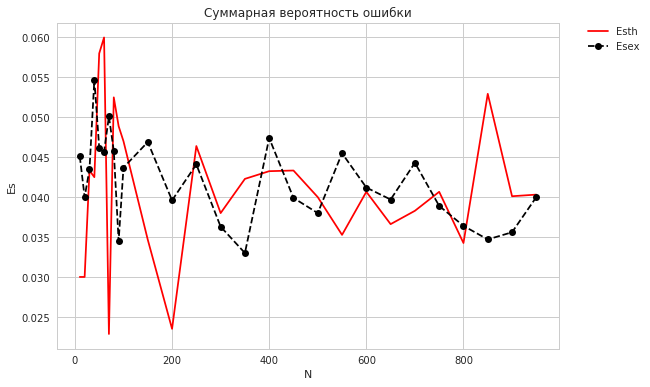

In [28]:
plt.plot(Nn,Esth2,'-r',label = 'Esth')
plt.plot(Nn,Esex2,'--ok',label = 'Esex')
plt.title( 'Cуммарная вероятность ошибки')
plt.xlabel('N')
plt.ylabel('Es')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Суммарная вероятность ошибки распознавания локализируется около 0.04. Можно сделать вывод, что в данном случае оценка плотности с помощью метода kNN достаточно точная.

### Сравнение ошибок распознвания для  kNN и алгоритма из lab3

Тряхнем стариной и посчитаем экспериментальные ошибки как в лабораторной №3:

In [515]:
x = np.matrix(np.ones((n,1)))
u = np.zeros([M,1])
P_err_experiment = np.zeros((M,M))
XK = np.zeros((n, 3 * K))
C_= [np.linalg.inv(C1), np.linalg.inv(C2),np.linalg.inv(C3)]

In [516]:
for nn in range(ln):
    K = Nn[nn]
    for k in range(K):
        for i in range(M):
            x_ = randncor(n,1,C[i])
            x[:n,0] = m[i].reshape(-1,1) + x_
            XK[:n, (i - 1) * K + k] = x[:n,0].ravel()
            for j in range(M):
                u[j]= -0.5*np.transpose(x-m[j].reshape(-1,1))*C_[j]*(x-m[j].reshape(-1,1))-0.5*np.linalg.det(C[j])+np.log(pw[j])
            um,umi = u.max(), np.where(u == u.max())[0]
            if i == umi:
                P_err_experiment[i,umi] = P_err_experiment[i,umi]+1
            else:
                 P_err_experiment[i,np.abs(P_err_experiment.shape[1]-umi-1)] = P_err_experiment[i,np.abs(P_err_experiment.shape[1]-umi-1)]+1
    P_err_experiment = P_err_experiment/K
    Ekek2[nn]=Ekek2[nn]+(1-np.sum(pw*np.diag(P_err_experiment)))

Сравним их с экспериментальными ошибками, полученными при применении метода kNN:

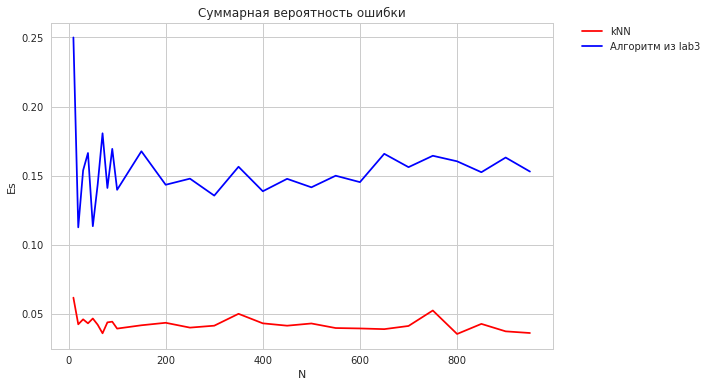

In [521]:
plt.plot(Nn,Esex2,'-r',label = 'kNN')
plt.plot(Nn,Ekek2,'-b',label='Алгоритм из lab3')
plt.title( 'Cуммарная вероятность ошибки')
plt.xlabel('N')
plt.ylabel('Es');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Метод k ближайших соседей справляется с оценкой плотности распределения СВ лучше, чем алгоритм из лабораторной работы №3.

## Визуализация плотностей распределения классов и их оценки

In [21]:
x1=np.arange(-15,15,0.5)
x2= np.arange(-10,11,0.5)
X1,X2=np.meshgrid(x1,x2)
x=np.vstack((X1.ravel(),X2.ravel()))
XN = generate_sample(n,M,NN,m,C,vis = False)
x_ = x.T

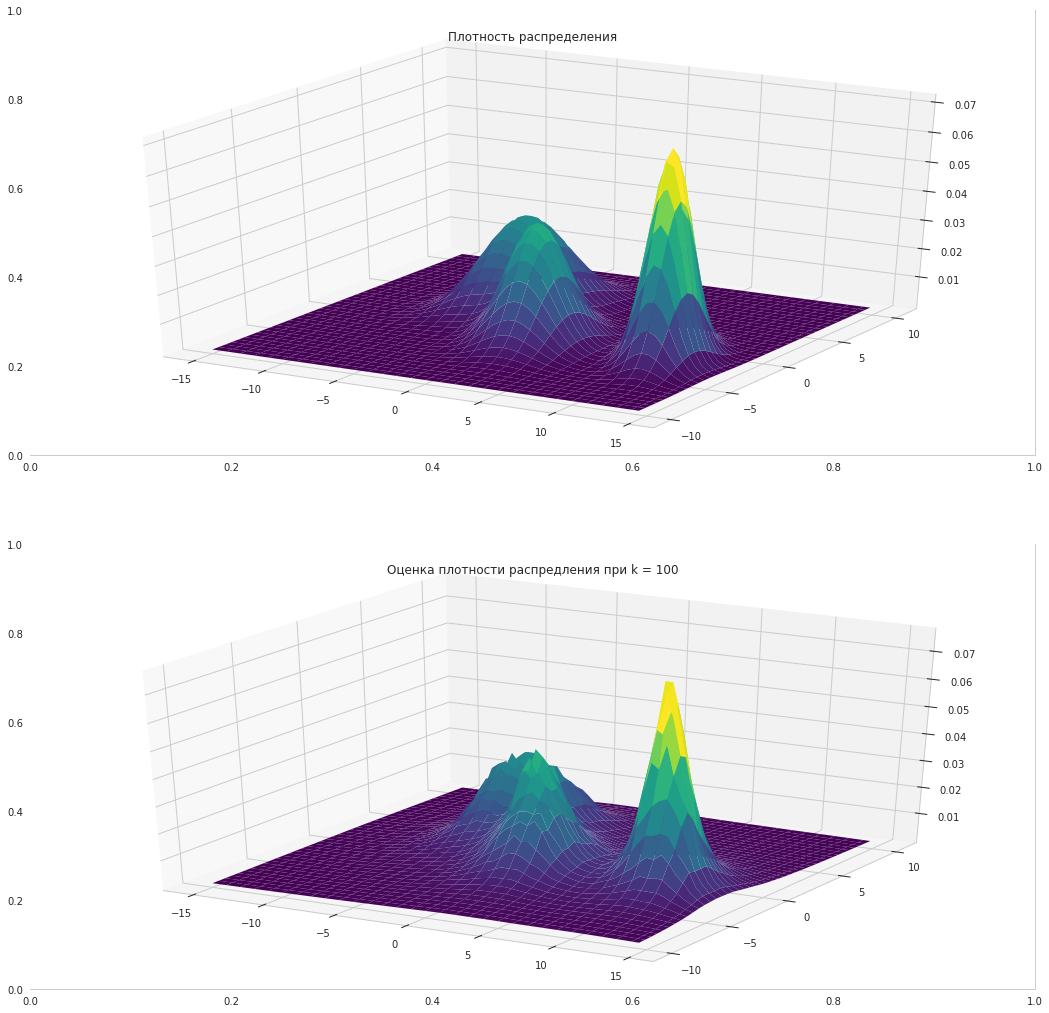

In [23]:
p= 0
p2x = 0
k = 100
fig,axs = plt.subplots(2,1,figsize=(18,18))
for i in range(M):
    p+=multivariate_normal.pdf(x_,m[i],C[i])
    p2x+=knn(x,XN[i],100)
pi=np.reshape(p,(len(x2),len(x1)))
p2x=np.reshape(p2x,(len(x2),len(x1)))

ax = fig.add_subplot(2,1,1,projection='3d')
ax.plot_surface(X1, X2, pi, cmap=plt.cm.viridis, linewidth=0.2);
ax.set_title('Плотность распределения')

ax = fig.add_subplot(2,1,2,projection='3d')
ax.plot_surface(X1, X2, p2x, cmap=plt.cm.viridis, linewidth=0.2);
ax.set_title('Оценка плотности распредления при k = {}'.format(k));